In [81]:
import torch
import torch.nn as nn
import torch.distributions as D
import torchvision
from torchvision import transforms
#from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import pdb

%matplotlib inline

In [82]:
import warnings
warnings.filterwarnings('ignore')

### Loading MNIST dataset

In [83]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True, 
                                      download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = tuple(str(i) for i in range(10))

In [84]:
trainloader.dataset.train_data.shape, testloader.dataset.test_data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

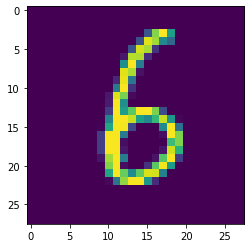

In [119]:
i = np.random.randint(low=0, high=60000)
plt.imshow(trainloader.dataset.train_data[i].numpy(), cmap=None);

In [136]:
X_train, y_train = trainloader.dataset.train_data, trainloader.dataset.train_labels
X_text, y_test = testloader.dataset.test_data, testloader.dataset.test_labels

In [137]:
device = "cpu" if torch.cuda.is_available() else "cuda:0"

In [139]:
std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32), #for sampling
                                       scale=torch.tensor(1., device=device, dtype=torch.float32))

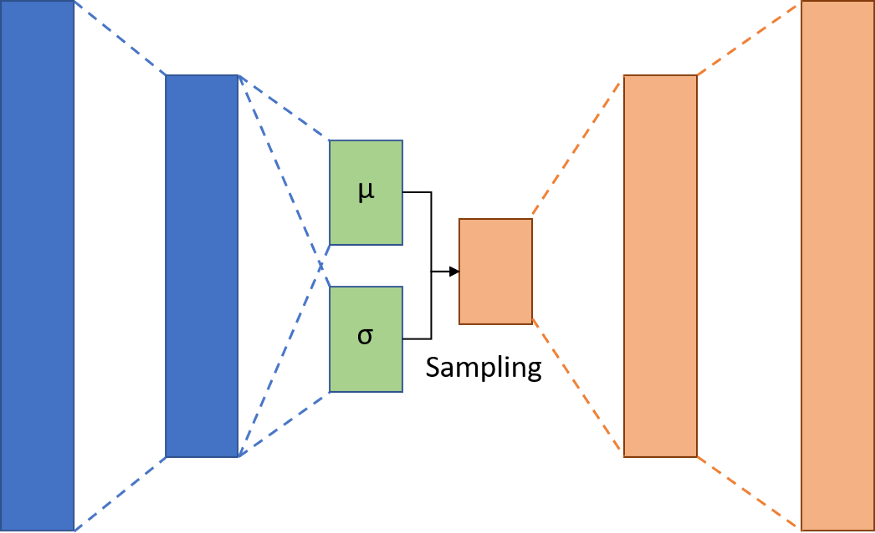

In [170]:
class VAE():
    def __init__(self, beta=1):
        self.encoder = nn.Sequential(nn.Linear(784,196),
                                     nn.ReLU(),
                                     nn.BatchNorm1d(196, momentum = 0.7),
                                     nn.Linear(196,49),
                                     nn.ReLU(),
                                     nn.BatchNorm1d(49, momentum = 0.7),
                                     nn.Linear(49,28),
                                     nn.LeakyReLU())
        self.hidden_mu = nn.Linear(28,28)
        self.hidden_log_var = nn.Linear(28,28)
        self.decoder = nn.Sequential(nn.Linear(28,49),
                                     nn.ReLU(),
                                     nn.Linear(49,196),
                                     nn.ReLU(),
                                     nn.Linear(196,784),
                                     nn.Tanh())
        self.beta = beta # in case of disentangled VAE !=1 and is passed as a parameter
        
    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.hidden_mu(hidden)
        log_var = self.hidden_log_var(hidden) # getting mu and sigma for reparametrization trick
        return mu, log_var

    def reparametrize(self, mu, log_var):
        sigma = torch.exp(log_var)
        z = std_normal.sample((28,28)) # TODO: fix the sample shape
        return mu + sigma*z
    
    def decode(self, x):
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        hidden = self.reparametrize(mu, log_var) # bottleneck
        output = self.decoder(hidden) # x_out
        return mu, log_var, output 
    

In [171]:
vae_encoder = VAE().encoder
#ae_h_mu = VAE().hidden_mu
#ae_h_log_var = VAE().hidden_log_var

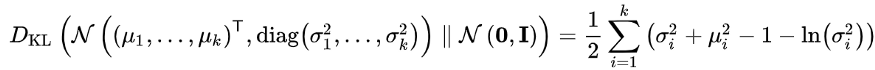

In [172]:
#loss_fn = - 0.5 * ((torch.exp(log_var) + mu**2 - 1 - log_var).sum(1)).mean() + std_normal.log_prob(x)
optimizer = torch.optim.Adam(params = vae_encoder.parameters(), lr=1e-2)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.75)

In [175]:
from tqdm import tqdm_notebook

In [176]:
net = VAE(1)

In [180]:
losses=[]

In [183]:
running_loss = 0.0
for i, batch in enumerate(tqdm_notebook(trainloader)):   
    
    optimizer.zero_grad()

    x, _ = batch
    mu, log_var, x_out = net.forward(x)
    kl_loss = - 0.5 * ((torch.exp(log_var) + mu**2 - 1 - log_var).sum(1)).mean()
    recon_loss_criterion = std_normal.log_prob(x_out)
    loss = recon_loss + kl_loss
    
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 2000 == 1999:
        losses.append(running_loss/2000)
        running_loss = 0.0

  0%|          | 0/15000 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 shapes cannot be multiplied (112x28 and 784x196)

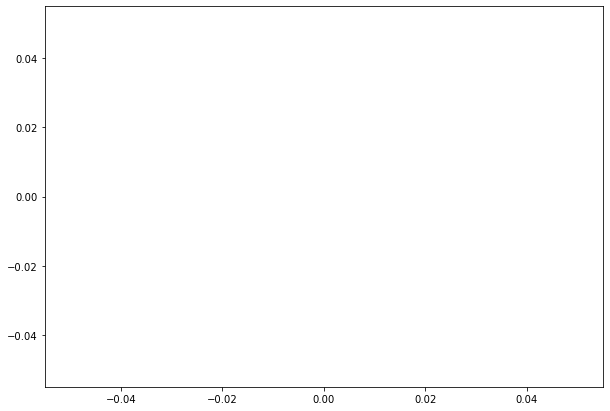

In [181]:
plt.figure(figsize=(10,7))
plt.plot(np.arange(len(losses)), losses)
plt.show()